In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, List

In [2]:
@dataclass
class Function:
    func: Callable[[float], float]
    derivative: Callable[[float], float]

In [3]:
class Optimizer:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return None

In [4]:
class GD(Optimizer):
    def fit(self, X, y):
        for i in range(X.shape[0]):
            # Прямой проход (вычисление предсказания)
            outputs = self.model.predict(X[i], get_outputs=True)

            # Вычисление градиента функции потерь
            loss_gradient = self.model.loss_function.derivative(outputs[-1], y[i])

            # Обратное распространение ошибки для выходного слоя
            # Вычисление градиента
            gradient = self.model.activation_function.derivative(outputs[-1])
            delta = self.model.learning_rate * gradient * loss_gradient
            self.model.weights[-1] -= np.outer(delta, outputs[-2])
            self.model.biases[-1] -= delta

            # Обратное распространение для скрытых слоев с функцией активации ReLU
            for j in range(len(self.model.hidden_layers_sizes) - 1, -1, -1):
                gradient = self.model.activation_function.derivative(outputs[j + 1])
                delta = self.model.learning_rate * gradient * np.dot(self.model.weights[j + 1].T, delta)
                self.model.weights[j] -= np.outer(delta, outputs[j])
                self.model.biases[j] -= delta

In [5]:

class SGD(Optimizer):
    def __init__(self, model):
        super().__init__(model)
        
        self.batch_size = 50

    def mean_from_batch(self, batch_outputs, function):
        return np.mean([
                    function(batch_outputs[j], j)
                    for j in range(self.batch_size)
                ], axis=0)

    def fit(self, X, y):
        indexes = np.arange(X.shape[0])
        np.random.shuffle(indexes)
        X = X[indexes]
        y = y[indexes]

        for i in range(0, X.shape[0], self.batch_size):
            batch_outputs = np.array([
                self.model.predict(X[j], get_outputs=True)
                for j in range(i, i + self.batch_size)
            ], dtype=object)
            
            loss_gradient = self.mean_from_batch(batch_outputs,
                lambda outputs, j: self.model.loss_function.derivative(outputs[-1], y[i + j])
            )

            gradient = self.mean_from_batch(batch_outputs,
                lambda outputs, _: self.model.activation_function.derivative(outputs[-1]))
            delta = self.model.learning_rate * gradient * loss_gradient

            self.model.weights[-1] -= self.mean_from_batch(batch_outputs,
                lambda outputs, _: np.outer(delta, outputs[-2]))
            self.model.biases[-1] -= delta

            for j in range(len(self.model.hidden_layers_sizes) - 1, -1, -1):
                gradient = self.mean_from_batch(batch_outputs,
                    lambda outputs, _: self.model.activation_function.derivative(outputs[j + 1]))
                delta = self.model.learning_rate * gradient * np.dot(self.model.weights[j + 1].T, delta)
            
                self.model.weights[j] -= self.mean_from_batch(batch_outputs,
                    lambda outputs, _: np.outer(delta, outputs[j]))
                self.model.biases[j] -= delta

In [6]:
class NAG(Optimizer):
    def __init__(self, model):
        super().__init__(model)
        
        self.momentums_weights = [np.zeros(weights.shape) for weights in self.model.weights]
        self.momentums_biases = [np.zeros(biases.shape) for biases in self.model.biases]

    def fit(self, X, y):
        for i in range(X.shape[0]):
            for j in range(len(self.model.weights)):
                self.model.weights[j] -= self.momentums_weights[j]
                self.model.biases[j] -= self.momentums_biases[j]
            outputs = self.model.predict(X[i], get_outputs=True)

            loss_gradient = self.model.loss_function.derivative(outputs[-1], y[i])

            gradient = self.model.activation_function.derivative(outputs[-1])
            delta = self.model.learning_rate * gradient * loss_gradient
            delta_weights = np.outer(delta, outputs[-2])
            
            self.momentums_weights[-1] += delta_weights
            self.model.weights[-1] -= delta_weights
            
            self.momentums_biases[-1] += delta
            self.model.biases[-1] -= delta

            for j in range(len(self.model.hidden_layers_sizes) - 1, -1, -1):
                gradient = self.model.activation_function.derivative(outputs[j + 1])
                delta = self.model.learning_rate * gradient * np.dot(self.model.weights[j + 1].T, delta)
                delta_weights = np.outer(delta, outputs[j])
                
                self.momentums_weights[j] += delta_weights
                self.model.weights[j] -= self.momentums_weights[j]

                self.momentums_biases[j] += delta
                self.model.biases[j] -= delta

In [7]:

class Adagrad(Optimizer):
    def __init__(self, model):
        super().__init__(model)
        
        self.sum_grads_weights = [np.zeros(weights.shape) for weights in self.model.weights]
        self.sum_grads_biases = [np.zeros(biases.shape) for biases in self.model.biases]
        self.eps = 1e-8

    def fit(self, X, y):
        for i in range(X.shape[0]):
            outputs = self.model.predict(X[i], get_outputs=True)

            loss_gradient = self.model.loss_function.derivative(outputs[-1], y[i])

            gradient = self.model.activation_function.derivative(outputs[-1])
            delta = gradient * loss_gradient
            delta_weights = np.outer(delta, outputs[-2])
            
            self.sum_grads_weights[-1] += delta_weights ** 2
            self.model.weights[-1] -= self.model.learning_rate * delta_weights * (self.sum_grads_weights[-1] + self.eps) ** -.5
            
            self.sum_grads_biases[-1] += delta ** 2
            self.model.biases[-1] -= self.model.learning_rate * delta * (self.sum_grads_biases[-1] + self.eps) ** -.5

            for j in range(len(self.model.hidden_layers_sizes) - 1, -1, -1):
                gradient = self.model.activation_function.derivative(outputs[j + 1])
                delta = gradient * np.dot(self.model.weights[j + 1].T, delta)
                delta_weights = np.outer(delta, outputs[j])
                
                self.sum_grads_weights[j] += delta_weights ** 2
                self.model.weights[j] -= self.model.learning_rate * delta_weights * (self.sum_grads_weights[j] + self.eps) ** -.5

                self.sum_grads_biases[j] += delta ** 2
                self.model.biases[j] -= self.model.learning_rate * delta * (self.sum_grads_biases[j] + self.eps) ** -.5

In [8]:
class Adam(Optimizer):
    def __init__(self, model):
        super().__init__(model)
        
        self.momentums_weights = [np.zeros(weights.shape) for weights in self.model.weights]
        self.momentums_biases = [np.zeros(biases.shape) for biases in self.model.biases]

        self.sum_grads_weights = [np.zeros(weights.shape) for weights in self.model.weights]
        self.sum_grads_biases = [np.zeros(biases.shape) for biases in self.model.biases]

        self.beta1 = 0.9
        self.beta2 = 0.99
        self.eps = 1e-8

    def fit(self, X, y):
        for i in range(X.shape[0]):
            outputs = self.model.predict(X[i], get_outputs=True)

            loss_gradient = self.model.loss_function.derivative(outputs[-1], y[i])

            gradient = self.model.activation_function.derivative(outputs[-1])
            delta = gradient * loss_gradient
            delta_weights = np.outer(delta, outputs[-2])
            
            self.momentums_weights[-1] = self.beta1 * self.momentums_weights[-1] + (1 - self.beta1) * delta_weights
            self.sum_grads_weights[-1] = self.beta2 * self.sum_grads_weights[-1] + (1 - self.beta2) * delta_weights ** 2
            self.model.weights[-1] -= self.model.learning_rate * (self.sum_grads_weights[-1] + self.eps) ** -.5 * self.momentums_weights[-1]
            
            self.momentums_biases[-1] = self.beta1 * self.momentums_biases[-1] + (1 - self.beta1) * delta
            self.sum_grads_biases[-1] = self.beta2 * self.sum_grads_biases[-1] + (1 - self.beta2) * delta ** 2
            self.model.biases[-1] -= self.model.learning_rate * (self.sum_grads_biases[-1] + self.eps) ** -.5 * self.momentums_biases[-1]

            for j in range(len(self.model.hidden_layers_sizes) - 1, -1, -1):
                gradient = self.model.activation_function.derivative(outputs[j + 1])
                delta = gradient * np.dot(self.model.weights[j + 1].T, delta)
                delta_weights = np.outer(delta, outputs[j])
                
                self.momentums_weights[j] = self.beta1 * self.momentums_weights[j] + (1 - self.beta1) * delta_weights
                self.sum_grads_weights[j] = self.beta2 * self.sum_grads_weights[j] + (1 - self.beta2) * delta_weights ** 2
                self.model.weights[j] -= self.model.learning_rate * (self.sum_grads_weights[j] + self.eps) ** -.5 * self.momentums_weights[j]
                
                self.momentums_biases[j] = self.beta1 * self.momentums_biases[j] + (1 - self.beta1) * delta
                self.sum_grads_biases[j] = self.beta2 * self.sum_grads_biases[j] + (1 - self.beta2) * delta ** 2
                self.model.biases[j] -= self.model.learning_rate * (self.sum_grads_biases[j] + self.eps) ** -.5 * self.momentums_biases[j]

In [17]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, List

@dataclass
class Function:
    func: Callable[[float], float]
    derivative: Callable[[float], float]

class Perceptron:
    def __init__(
        self,
        input_layer_size: int,
        hidden_layers_sizes: tuple,
        output_layer_size: int,
        init_weights_function: Callable[[tuple], tuple],
        loss_function: Function,
        optimizer: Optimizer,
        epochs: int,
        learning_rate: float = 0.01,
    ):
        self.input_layer_size = input_layer_size
        self.hidden_layers_sizes = hidden_layers_sizes
        self.output_layer_size = output_layer_size
        self.loss_function = loss_function
        self.epochs = epochs
        self.learning_rate = learning_rate
    
        self.activation_function = ReLU

        # Инициализация весов и смещений (biases)
        self.weights = []
        self.biases = []

        # Веса между входным слоем и первым скрытым слоем
        self.weights.append(init_weights_function((hidden_layers_sizes[0], input_layer_size)))
        self.biases.append(np.random.randn(hidden_layers_sizes[0]))

        # Веса между скрытыми слоями
        for i in range(1, len(hidden_layers_sizes)):
            self.weights.append(init_weights_function((hidden_layers_sizes[i], hidden_layers_sizes[i - 1])))
            self.biases.append(np.random.randn(hidden_layers_sizes[i]))

        # Веса между последним скрытым слоем и выходным слоем
        self.weights.append(init_weights_function((output_layer_size, hidden_layers_sizes[-1])))
        self.biases.append(np.random.randn(output_layer_size))

        self.optimizer = optimizer(self)

    def predict(self, X: np.ndarray, get_outputs: bool=False, get_probabilities: bool=False) -> int | list:
        outputs = [X]

        # Прямой проход через скрытые слои с функцией активации ReLU
        for i in range(len(self.hidden_layers_sizes)):
            z = np.dot(self.weights[i], outputs[-1]) + self.biases[i]
            outputs.append(np.maximum(0, z))

        # Прямой проход через выходной слой с функцией активации Softmax
        z = np.dot(self.weights[-1], outputs[-1]) + self.biases[-1]
        outputs.append(np.exp(z) / np.sum(np.exp(z)))

        if get_outputs:
            return outputs
        if get_probabilities:
            return outputs[-1]
        return int(np.argmax(outputs[-1]))

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        y_one_hot = np.zeros((len(y), self.output_layer_size))
        for i, label in enumerate(y):
            y_one_hot[i, label] = 1

        for epoch in range(self.epochs):
            self.optimizer.fit(X, y_one_hot)

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> float:
        correct_predictions = 0

        for i in range(len(X)):
            prediction = self.predict(X[i])
            if prediction == y[i]:
                correct_predictions += 1

        # Возвращаем долю правильных предсказаний
        return correct_predictions / len(X)

    def validate(self, X_val: np.ndarray, y_val: np.ndarray) -> float:
        total_loss = 0.0
        n = len(X_val)

        # Преобразуем метки в one-hot encoding, если это необходимо
        y_one_hot = np.zeros((len(y_val), self.output_layer_size))
        for i, label in enumerate(y_val):
            y_one_hot[i, label] = 1

        for i in range(n):
            # Прямой проход для получения предсказания
            prediction = self.predict(X_val[i], get_probabilities=True)

            # Вычисляем функцию потерь для текущего примера
            loss = self.loss_function.func(prediction, y_one_hot[i])
            total_loss += loss

        # Возвращаем среднее значение функции потерь
        return total_loss / n

In [10]:

def he_init(size):
    return np.random.randn(*size) * np.sqrt(2.0 / size[1])

k = 3
ReLU = Function(
    func=lambda x: np.where(x > 0, k * x, 0),
    derivative=lambda x: np.where(x > 0, k, 0),
)

MSE = Function(
    func=lambda y_pred, y_true: np.mean((y_true - y_pred) ** 2),
    derivative=lambda y_pred, y_true: 2 * (y_pred - y_true) / y_true.size,
)

from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28**2) / 255
x_test = x_test.reshape(-1, 28**2) / 255
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [18]:
def get_accuracies(optimizer):
    model = copy.deepcopy(model_default)
    model.optimizer = optimizer(model)

    accuracies = np.array([model.evaluate(x_test, y_test)])
    losses = np.array([model.validate(x_test, y_test)])
    print(accuracies[-1], losses[-1])

    for i in range(1, epochs_count + 1):
        model.fit(x_train[:1000], y_train[:1000])
        accuracies = np.append(accuracies, model.evaluate(x_test, y_test))
        losses = np.append(losses, model.validate(x_test, y_test))
        print(accuracies[-1], losses[-1])
    
    print()
    return accuracies, losses

In [12]:
model_default = Perceptron(
    input_layer_size=28**2,
    hidden_layers_sizes=(256,)*4,
    output_layer_size=10,
    init_weights_function=he_init,
    loss_function=MSE,
    optimizer=GD,
    epochs=1,
    learning_rate=1e-6,
)

In [13]:
epochs_count = 4
epoch_list = list(range(0, epochs_count + 1))

In [22]:
results_GD = get_accuracies(GD)
results_SGD = get_accuracies(SGD)
results_NAG = get_accuracies(NAG)
results_Adagrad = get_accuracies(Adagrad)
results_Adam = get_accuracies(Adam)

0.1009 0.13524406746532305
0.1011 0.13081233671594356
0.1011 0.12687405169293606
0.1016 0.1234378574025103
0.1021 0.12047216513553433



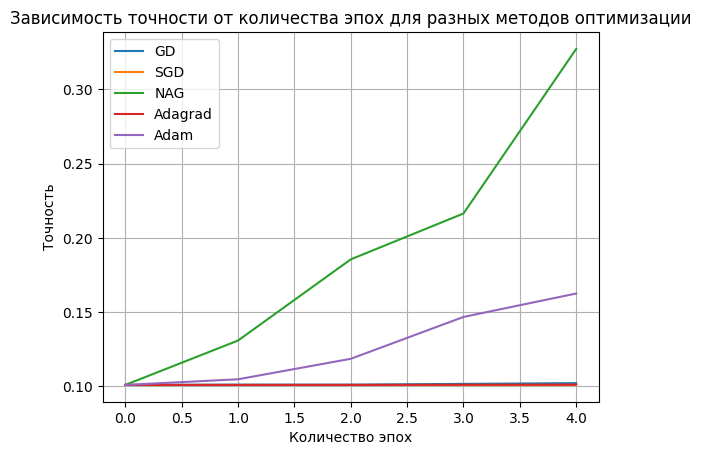

In [23]:
plt.plot(epoch_list, results_GD[0], label="GD")
plt.plot(epoch_list, results_SGD[0], label="SGD")
plt.plot(epoch_list, results_NAG[0], label="NAG")
plt.plot(epoch_list, results_Adagrad[0], label="Adagrad")
plt.plot(epoch_list, results_Adam[0], label="Adam")

plt.title("Зависимость точности от количества эпох для разных методов оптимизации")
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.grid(True)
plt.legend()
plt.show()

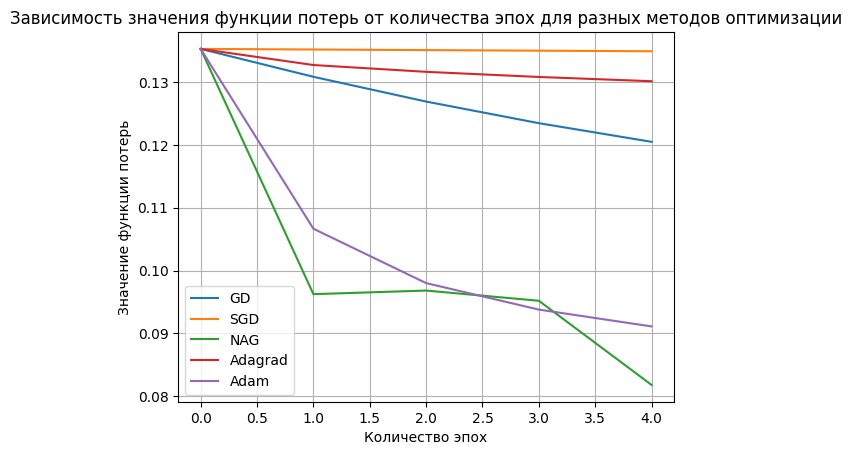

In [25]:
plt.plot(epoch_list, results_GD[1], label="GD")
plt.plot(epoch_list, results_SGD[1], label="SGD")
plt.plot(epoch_list, results_NAG[1], label="NAG")
plt.plot(epoch_list, results_Adagrad[1], label="Adagrad")
plt.plot(epoch_list, results_Adam[1], label="Adam")

plt.title("Зависимость значения функции потерь от количества эпох для разных методов оптимизации")
plt.xlabel("Количество эпох")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()